In [10]:
from liblinear.liblinearutil import *
from itertools import combinations_with_replacement
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# Dataset

- `mnist.scale` for training
- `mnist.scale.t` for testing


In [5]:
train_data = 'mnist.scale'
test_data = 'mnist.scale.t'

## Read and save data

The training data is saved in the `X_train` list, with each element being a dictionary of features.
example format: {153: 0.0117647, 154: 0.0705882, 155: 0.0705882, ...}

The corresponding label list is saved in `y_train`.

Similarily, the testing data is saved in `X_test` and the corresponding label list is saved in `y_test`.

In [6]:
def read_linear_format(file_path):
    X, y = [], []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts[0] == '2' or parts[0] == '6':
                y.append(int(parts[0]))  
                features = {}
                for item in parts[1:]:
                    index, value = item.split(":")
                    features[int(index)] = float(value)
                X.append(features)
    return X, y

X_train, y_train = read_linear_format(train_data)
X_test, y_test = read_linear_format(test_data)


### Example of the saved data format

- Note: This example has not done selecting out the class 2 and 6 examples.

In [5]:
X = []
with open(train_data, 'r') as f:
    for line in f:
        print("original line:", line)
        parts = line.strip().split()
        print("parts after stripping:", parts)
        features = {}
        for item in parts[1:]:
            index, value = item.split(":")
            features[int(index)] = float(value)
        X.append(features)
        break
        
print("X after first line processed:", X)


original line: 5 153:0.0117647 154:0.0705882 155:0.0705882 156:0.0705882 157:0.494118 158:0.533333 159:0.686275 160:0.101961 161:0.65098 162:1 163:0.968627 164:0.498039 177:0.117647 178:0.141176 179:0.368627 180:0.603922 181:0.666667 182:0.992157 183:0.992157 184:0.992157 185:0.992157 186:0.992157 187:0.882353 188:0.67451 189:0.992157 190:0.94902 191:0.764706 192:0.25098 204:0.192157 205:0.933333 206:0.992157 207:0.992157 208:0.992157 209:0.992157 210:0.992157 211:0.992157 212:0.992157 213:0.992157 214:0.984314 215:0.364706 216:0.321569 217:0.321569 218:0.219608 219:0.152941 232:0.0705882 233:0.858824 234:0.992157 235:0.992157 236:0.992157 237:0.992157 238:0.992157 239:0.776471 240:0.713725 241:0.968627 242:0.945098 261:0.313725 262:0.611765 263:0.419608 264:0.992157 265:0.992157 266:0.803922 267:0.0431373 269:0.168627 270:0.603922 290:0.054902 291:0.00392157 292:0.603922 293:0.992157 294:0.352941 320:0.545098 321:0.992157 322:0.745098 323:0.00784314 348:0.0431373 349:0.745098 350:0.99

## $0/1$ error

In [7]:
def ZeroOneError(predictions, y):
    return sum(p_i != y_i for p_i, y_i in zip(predictions, y)) / len(predictions)

# Regularized logistic regression

## Original Formulation in README.md

As the explanation in the liblinear README file, for <u>L1-regularized logistic regression</u> `(-s 6)`, we solve

\begin{equation} \tag{$\star$}
\min_{\vec{w}} \sum |w_j| + C \sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation}

### Components of this equation

In this equation, the <u>L1 regularizer</u> is defined as:

\begin{equation*}
\Omega(\vec{w}) = \sum |w_j| = ||\vec{w}||_1
\end{equation*}
> info in Lec14 slide 18

- Note: using L1 regularization encourages sparsity, which means fewer parameters.

And the <u>in-sample error</u> for logistic regression is:

\begin{equation*}
E_{in}(\vec{w}) = \frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i))
\end{equation*}
> in textbook p.91

## Derivation of $C$

Since we knew that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N} \Omega(\vec{w})
\end{equation*}

We can derive that:

\begin{equation*}
E_{aug}(\vec{w}) = E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|
\end{equation*}

For minimization:

\begin{equation*}
\begin{split}
\argmin_{\vec{w}} E_{aug}(\vec{w}) 
&= \argmin_{\vec{w}} (E_{in}(\vec{w}) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{N}{\lambda}(\frac{1}{N}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \frac{\lambda}{N}\sum |w_j|) \\
&= \argmin_{\vec{w}} \frac{1}{\lambda}\sum \log(1 + \exp(-y_i \vec{w}^T\vec{x}_i)) + \sum |w_j|
\end{split}
\end{equation*}

Compare to the original equation marked with ($\star$), we can see that:

\begin{equation*}
C = \frac{1}{\lambda}
\end{equation*}



## Select the best $\lambda^*$

Selecting optimal $\lambda^*$ using the following equation:

\begin{equation*}
\lambda^* = \argmin_{\log_{10}(\lambda) \in \{-2, -1, 0, 1, 2, 3\}} E_{in}(\vec{w}_{\lambda})
\end{equation*}



## get amount of non-zeros

To get the amount of non-zero components in the model, we can use the function `.get_decfun()`:

```python
[W, b] = model_.get_decfun()
```




# 3 folds cross validation
> textbook p.150

In this problem, we're asked to conduct 3-folds cross validation on the training data, which means we do the following steps:
1. partition the training data into 3 disjoint subsets (folds): `D_1, D_2, D_3`, each of size $\approx \frac{N}{3}$
2. for each fold `D_i`, we train the model using the remaining 2 folds, and evaluate the model on `D_i`
> Each set serves as a validation set to compute the validation error for the hypothesis $g$ learned on a training set which is the complement of the validation set $D \setminus D_i$

$\rightarrow$ we select the optimal $\lambda^*$ by this validation error $E_{CV}$

3. rerun the model with the best $\lambda^*$ on the whole training set
4. evaluate the model on the testing data


In [9]:
Eouts = []

for experiment in tqdm(range(1126)):

    np.random.seed(experiment)
    
    total_size = len(X_train)
    indices = np.random.permutation(total_size)
    
    fold_size = total_size // 3

    fold1_indices = indices[:fold_size]
    fold2_indices = indices[fold_size:2*fold_size]
    fold3_indices = indices[2*fold_size:]  

    X_fold1 = [X_train[i] for i in fold1_indices]
    X_fold2 = [X_train[i] for i in fold2_indices] 
    X_fold3 = [X_train[i] for i in fold3_indices]

    y_fold1 = [y_train[i] for i in fold1_indices]
    y_fold2 = [y_train[i] for i in fold2_indices]
    y_fold3 = [y_train[i] for i in fold3_indices]


    min_Ecv = np.inf
    opt_log10_lambda = 0
    for log10_lambda in (-2, -1, 0, 1, 2, 3):
        each_fold_as_valid_err = []  
        c = 1 / (10 ** log10_lambda)
        
        for i in range(1,4):
            if i == 1:
                X_subtrain = X_fold2 + X_fold3
                y_subtrain = y_fold2 + y_fold3
                X_validation = X_fold1
                y_validation = y_fold1
            elif i == 2:
                X_subtrain = X_fold1 + X_fold3
                y_subtrain = y_fold1 + y_fold3
                X_validation = X_fold2
                y_validation = y_fold2
            else:
                X_subtrain = X_fold1 + X_fold2
                y_subtrain = y_fold1 + y_fold2
                X_validation = X_fold3
                y_validation = y_fold3

            subtrain_prob = problem(y_subtrain, X_subtrain)
            param = parameter('-s 6 -c ' + str(c))
            model_by_subtrain = train(subtrain_prob, param)

            validation_label, _, _ = predict(y_validation, X_validation, model_by_subtrain)
            validation_err = ZeroOneError(validation_label, y_validation)
            each_fold_as_valid_err.append(validation_err)
        
        Ecv_each_lambda = np.mean(each_fold_as_valid_err)
        
        if Ecv_each_lambda == min_Ecv:
            opt_log10_lambda = max(opt_log10_lambda, log10_lambda)  # break tie by choosing larger lambda
        elif Ecv_each_lambda < min_Ecv:
            min_Ecv = Ecv_each_lambda
            opt_log10_lambda = log10_lambda

    whole_train_prob = problem(y_train, X_train)
    param_with_opt_lambda = parameter('-s 6 -c ' + str(1 / (10 ** opt_log10_lambda)))
    whole_train_model = train(whole_train_prob, param_with_opt_lambda)

    test_label, _, _ = predict(y_test, X_test, whole_train_model)
    Eout = ZeroOneError(test_label, y_test)
    
    Eouts.append(Eout)

  0%|          | 0/1126 [00:00<?, ?it/s]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18690.335089
#nonzeros/#features = 550/723
Accuracy = 98.2314% (3888/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19004.751629
#nonzeros/#features = 551/727
Accuracy = 98.4336% (3896/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16473.893203
#nonzeros/#features = 556/727
Accuracy = 98.2323% (3890/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finish

  0%|          | 1/1126 [00:12<3:55:48, 12.58s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.093176
#nonzeros/#features = 379/727
Accuracy = 98.6935% (1964/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15621.270335
#nonzeros/#features = 554/727
Accuracy = 97.903% (3875/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19681.096679
#nonzeros/#features = 556/723
Accuracy = 98.4841% (3898/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

  0%|          | 2/1126 [00:24<3:52:49, 12.43s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3586.118774
#nonzeros/#features = 508/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18794.993247
#nonzeros/#features = 551/727
Accuracy = 98.1304% (3884/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17874.063866
#nonzeros/#features = 555/724
Accuracy = 98.2567% (3889/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finishe

  0%|          | 3/1126 [00:37<3:52:30, 12.42s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3616.247138
#nonzeros/#features = 514/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18746.656812
#nonzeros/#features = 551/727
Accuracy = 98.2567% (3889/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17079.085360
#nonzeros/#features = 558/724
Accuracy = 98.4336% (3896/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finishe

  0%|          | 4/1126 [00:50<3:54:30, 12.54s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 554.191768
#nonzeros/#features = 386/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17842.294603
#nonzeros/#features = 554/727
Accuracy = 98.3325% (3892/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16761.664411
#nonzeros/#features = 550/727
Accuracy = 98.383% (3894/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished,

  0%|          | 5/1126 [01:02<3:53:45, 12.51s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.954842
#nonzeros/#features = 391/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18741.257845
#nonzeros/#features = 551/727
Accuracy = 98.5851% (3902/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17667.888459
#nonzeros/#features = 558/723


  0%|          | 5/1126 [01:03<3:58:53, 12.79s/it]

Accuracy = 98.5346% (3900/3958) (classification)


KeyboardInterrupt: 

## Converted version to run in parallel

In [11]:
def run_single_experiment(experiment):
    np.random.seed(experiment)
    
    total_size = len(X_train)
    indices = np.random.permutation(total_size)
    
    fold_size = total_size // 3

    fold1_indices = indices[:fold_size]
    fold2_indices = indices[fold_size:2*fold_size]
    fold3_indices = indices[2*fold_size:]  

    X_fold1 = [X_train[i] for i in fold1_indices]
    X_fold2 = [X_train[i] for i in fold2_indices] 
    X_fold3 = [X_train[i] for i in fold3_indices]

    y_fold1 = [y_train[i] for i in fold1_indices]
    y_fold2 = [y_train[i] for i in fold2_indices]
    y_fold3 = [y_train[i] for i in fold3_indices]

    min_Ecv = np.inf
    opt_log10_lambda = 0
    for log10_lambda in (-2, -1, 0, 1, 2, 3):
        each_fold_as_valid_err = []  
        c = 1 / (10 ** log10_lambda)
        
        for i in range(1,4):
            if i == 1:
                X_subtrain = X_fold2 + X_fold3
                y_subtrain = y_fold2 + y_fold3
                X_validation = X_fold1
                y_validation = y_fold1
            elif i == 2:
                X_subtrain = X_fold1 + X_fold3
                y_subtrain = y_fold1 + y_fold3
                X_validation = X_fold2
                y_validation = y_fold2
            else:
                X_subtrain = X_fold1 + X_fold2
                y_subtrain = y_fold1 + y_fold2
                X_validation = X_fold3
                y_validation = y_fold3

            subtrain_prob = problem(y_subtrain, X_subtrain)
            param = parameter('-s 6 -c ' + str(c))
            model_by_subtrain = train(subtrain_prob, param)

            validation_label, _, _ = predict(y_validation, X_validation, model_by_subtrain)
            validation_err = ZeroOneError(validation_label, y_validation)
            each_fold_as_valid_err.append(validation_err)
        
        Ecv_each_lambda = np.mean(each_fold_as_valid_err)
        
        if Ecv_each_lambda == min_Ecv:
            opt_log10_lambda = max(opt_log10_lambda, log10_lambda)  # break tie by choosing larger lambda
        elif Ecv_each_lambda < min_Ecv:
            min_Ecv = Ecv_each_lambda
            opt_log10_lambda = log10_lambda

    whole_train_prob = problem(y_train, X_train)
    param_with_opt_lambda = parameter('-s 6 -c ' + str(1 / (10 ** opt_log10_lambda)))
    whole_train_model = train(whole_train_prob, param_with_opt_lambda)

    test_label, _, _ = predict(y_test, X_test, whole_train_model)
    return ZeroOneError(test_label, y_test)

n_jobs = -1  
Eouts = Parallel(n_jobs=n_jobs)(
    delayed(run_single_experiment)(experiment) 
    for experiment in tqdm(range(1126))
)

  0%|          | 0/1126 [00:00<?, ?it/s]Python(4949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(4957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  1%|          | 10/1126 [00:00<01:27, 12.73it/s]

iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18899.965601
#nonzeros/#features = 555/723
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16025.600165
#nonzeros/#features = 560/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18754.002387
#nonzeros/#features = 556/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18944.916403
#nonzeros/#features = 549/727
iter   3  #CD cycles 1
ite

  1%|          | 10/1126 [00:10<01:27, 12.73it/s]

Accuracy = 98.4083% (3895/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2239.470658
#nonzeros/#features = 486/727
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2161.952329
#nonzeros/#features = 493/727
Accuracy = 98.1809% (3886/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2201.190976
#nonzeros/#features = 490/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.383% (3894/3958) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, 

  1%|▏         | 16/1126 [00:38<1:02:18,  3.37s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3641.063490
#nonzeros/#features = 514/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.078178
#nonzeros/#features = 375/727
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3615.064459
#nonzeros/#features = 509/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.4925% (1960/1990) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3599.789276
#nonzeros

  2%|▏         | 24/1126 [01:19<1:17:35,  4.22s/it]

Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 49.798% (1972/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 4
optimization finished, #iter = 6
Objective value = 5.484185
#nonzeros/#features = 1/727
Accuracy = 82.6768% (3274/3960) (classification)
Accuracy = 82.7525% (3277/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.911334
#nonzeros/#features = 383/727
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   1  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.380842
#nonzeros/#features = 394/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter

  3%|▎         | 32/1126 [01:56<1:20:32,  4.42s/it]

Accuracy = 82.5505% (3269/3960) (classification)
Accuracy = 50.4545% (1998/3960) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484303
#nonzeros/#features = 1/724
Accuracy = 82.5505% (3269/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.044436
#nonzeros/#features = 380/727
Accuracy = 98.392% (1958/1990) (classification)
Accuracy = 83.2323% (3296/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3607.810276
#nonzeros/#features = 511/727
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective val

  4%|▎         | 40/1126 [02:35<1:23:09,  4.59s/it]

Accuracy = 98.593% (1962/1990) (classification)
Accuracy = 82.9798% (3286/3960) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482086
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.484864
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.482561
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.476575
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
iter   4  #CD cycles 3
optimization finished, #iter = 4
Objective value = 5.482903
#nonzeros/#features = 1/727
Accuracy = 82.6768% (3274/3960) (classification)
Accuracy = 82.8283% (3280/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles

  4%|▍         | 48/1126 [03:22<1:30:18,  5.03s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485277
#nonzeros/#features = 1/724
Accuracy = 50.9091% (2016/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.484850
#nonzeros/#features = 1/727
Accuracy = 49.9495% (1977/3958) (classification)
Accuracy = 81.9101% (3242/3958) (classification)
Accuracy = 82.399% (3263/3960) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486644
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.481302
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.483471
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
optimization finis

  5%|▍         | 56/1126 [04:23<1:44:55,  5.88s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 2
optimization finished, #iter = 4
Objective value = 5.485086
#nonzeros/#features = 1/727
Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 81.9444% (3245/3960) (classification)
Accuracy = 82.7943% (3277/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484992
#nonzeros/#features = 1/727
Accuracy = 49.4697% (1959/3960) (classification)
Accuracy = 82.2638% (3256/3958) (classification)
Accuracy = 50.7832% (2010/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 2
optimization finished, #iter = 5
Objective value = 5.482007
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.485550
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3 

  6%|▌         | 64/1126 [05:13<1:46:20,  6.01s/it]

iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482203
#nonzeros/#features = 1/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483248
#nonzeros/#features = 1/727
Accuracy = 50.5558% (2001/3958) (classification)
Accuracy = 82.7185% (3274/3958) (classification)
Accuracy = 81.8434% (3241/3960) (classification)
Accuracy = 82.2475% (3257/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.482971
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485117
#nonzeros/#features = 1/722
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.486066
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483946
#n

  6%|▋         | 72/1126 [06:03<1:46:52,  6.08s/it]

Accuracy = 82.0364% (3247/3958) (classification)
Accuracy = 98.6935% (1964/1990) (classification)
Accuracy = 82.9459% (3283/3958) (classification)
Accuracy = 50.48% (1998/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485033
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.485327
#nonzeros/#features = 1/724
Accuracy = 50.0505% (1981/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 4
optimization finished, #iter = 2
Objective value = 5.483140
#nonzeros/#features = 1/727
Accuracy = 82.8449% (3279/3958) (classification)
Accuracy = 50.6316% (2004/3958) (classification)
Accuracy = 82.3737% (3262/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 4
optimization finished, #iter = 2
Objective value = 5.484736
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter 

  7%|▋         | 80/1126 [07:00<1:51:55,  6.42s/it]

Accuracy = 82.3396% (3259/3958) (classification)
Accuracy = 50.9096% (2015/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486863
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485054
#nonzeros/#features = 1/727
Accuracy = 50.0505% (1981/3958) (classification)
Accuracy = 83.2996% (3297/3958) (classification)
Accuracy = 49.7979% (1971/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 2
optimization finished, #iter = 4
Objective value = 5.485852
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485174
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.486376
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cy

  8%|▊         | 88/1126 [07:48<1:48:43,  6.28s/it]

Accuracy = 98.7437% (1965/1990) (classification)
Accuracy = 94.9242% (3759/3960) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485628
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483866
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485049
#nonzeros/#features = 1/727
Accuracy = 82.5922% (3269/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485273
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485597
#nonzeros/#features = 2/727
Accuracy = 83.0975% (3289/3958) (classification)
Accuracy = 82.0364% (3247/3958) (classification)
Accuracy = 82.9965% (3285/3958) (classification)
Accuracy = 82.2132% (3254/3958) (cla

  9%|▊         | 96/1126 [08:38<1:47:33,  6.27s/it]

Accuracy = 98.392% (1958/1990) (classification)
Accuracy = 49.9747% (1978/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484134
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.060088
#nonzeros/#features = 51/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483761
#nonzeros/#features = 1/727
Accuracy = 82.8954% (3281/3958) (classification)
Accuracy = 82.567% (3268/3958) (classification)
Accuracy = 95.1263% (3767/3960) (classification)
Accuracy = 49.8484% (1973/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482741
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.486258
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD

  9%|▉         | 104/1126 [09:26<1:45:33,  6.20s/it]

Accuracy = 95.3788% (3777/3960) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.310385
#nonzeros/#features = 52/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.209918
#nonzeros/#features = 54/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.482187
#nonzeros/#features = 1/727
Accuracy = 82.9712% (3284/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485233
#nonzeros/#features = 1/727
Accuracy = 50.3284% (1992/3958) (classification)
Accuracy = 95.6061% (3786/3960) (classification)
Accuracy = 95.1263% (3767/3960)

 10%|▉         | 112/1126 [10:13<1:43:13,  6.11s/it]

Accuracy = 98.392% (1958/1990) (classification)
Accuracy = 94.9975% (3760/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 3
iter   7  #CD cycles 1
iter   8  #CD cycles 5
optimization finished, #iter = 8
Objective value = 5.484957
#nonzeros/#features = 2/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.466221
#nonzeros/#features = 66/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
iter   4  #CD cycles 3
optimization finished, #iter = 4
Objective value = 5.483549
#nonzeros/#features = 1/727
Accuracy = 50.7327% (2008/3958) (classification)
Accuracy = 49.5452% (1961/3958) (classification)
Accuracy = 49.5705% (1962/3958) (classification)
Accuracy = 95.1768% (3769/3960) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value =

 11%|█         | 120/1126 [11:00<1:41:19,  6.04s/it]

Accuracy = 95.2501% (3770/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 4
optimization finished, #iter = 2
Objective value = 5.482232
#nonzeros/#features = 1/727
Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 95.6061% (3786/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 6
optimization finished, #iter = 3
Objective value = 5.483315
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 5
Objective value = 5.482579
#nonzeros/#features = 1/727
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.465450
#nonzeros/#features = 54/727
Accuracy = 49.5958% (1963/3958) (classification)
Accuracy = 49.8484% (1973/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1


 11%|█▏        | 128/1126 [11:48<1:40:09,  6.02s/it]

Accuracy = 95.4017% (3776/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483213
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 5.486319
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484332
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482842
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 82.0364% (3247/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.403868
#nonzeros/#features = 55/727
Accuracy = 83.0217% (3286/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles

 12%|█▏        | 136/1126 [12:38<1:40:26,  6.09s/it]

Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 95.2754% (3771/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.363947
#nonzeros/#features = 55/727
Accuracy = 49.3431% (1953/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.166083
#nonzeros/#features = 48/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486014
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484442
#nonzeros/#features = 1/727
Accuracy = 95.4545% (3780/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485688
#nonzeros/#features = 1/724
Accuracy = 95.0

 13%|█▎        | 144/1126 [13:29<1:40:41,  6.15s/it]

iter   2  #CD cycles 2
optimization finished, #iter = 2
Objective value = 5.484947
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.461115
#nonzeros/#features = 55/727
Accuracy = 96.1344% (3805/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484057
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.192869
#nonzeros/#features = 53/724
Accuracy = 82.6933% (3273/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485501
#nonzeros/#features = 1/727
Accuracy = 95.2273% (3771/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finis

 13%|█▎        | 152/1126 [14:17<1:39:23,  6.12s/it]

Accuracy = 95.404% (3778/3960) (classification)
Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484491
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.469813
#nonzeros/#features = 63/727
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.584439
#nonzeros/#features = 55/724
Accuracy = 95.4798% (3781/3960) (classification)
Accuracy = 82.8701% (3280/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.632331
#nonzeros/#features = 57/727
Accuracy = 49.3178% (1952/3958) (classification)
Accuracy = 94.9975% (3760/3958) (classification)
Accuracy = 95.3283% (3775/3

 14%|█▍        | 160/1126 [15:11<1:41:29,  6.30s/it]

Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 95.101% (3766/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 5.485731
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.708961
#nonzeros/#features = 55/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.484672
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.330112
#nonzeros/#features = 56/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objectiv

 15%|█▍        | 168/1126 [15:57<1:38:24,  6.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 5
optimization finished, #iter = 5
Objective value = 26.679151
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484377
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.485370
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.266302
#nonzeros/#features = 48/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.457293
#nonzeros/#features = 56/723
Accuracy = 96.2121% (3810/3960) (classification)
Accuracy = 50.4042% (1995/3958) (classification)
Accuracy = 82.2638%

 16%|█▌        | 176/1126 [16:49<1:38:43,  6.24s/it]

Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 95.048% (3762/3958) (classification)
Accuracy = 95.4545% (3780/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.484545
#nonzeros/#features = 1/727
Accuracy = 95.6291% (3785/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 4
iter   2  #CD cycles 1
optimization finished, #iter = 2
Objective value = 5.485898
#nonzeros/#features = 1/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.708512
#nonzeros/#features = 52/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.435549
#nonzeros/#features = 56/727
Accuracy = 82.8701% (3280/3958) (classification)
Accuracy = 96.0354% (3803/3960) (classification)
Accura

 16%|█▋        | 184/1126 [17:36<1:36:23,  6.14s/it]

Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 95.5533% (3782/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 3
optimization finished, #iter = 3
Objective value = 5.485086
#nonzeros/#features = 1/727
Accuracy = 95.5028% (3780/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.459990
#nonzeros/#features = 63/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.605111
#nonzeros/#features = 51/727
Accuracy = 82.9712% (3284/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.448868
#nonzeros/#features = 57/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3 

 17%|█▋        | 192/1126 [18:29<1:37:45,  6.28s/it]

Accuracy = 95.7049% (3788/3958) (classification)
Accuracy = 97.7525% (3871/3960) (classification)
Accuracy = 95.1743% (3767/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 4
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 2
optimization finished, #iter = 5
Objective value = 5.484734
#nonzeros/#features = 1/724
Accuracy = 96.0606% (3804/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.456214
#nonzeros/#features = 52/727
Accuracy = 49.1662% (1946/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.281826
#nonzeros/#features = 52/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #ite

 18%|█▊        | 200/1126 [19:23<1:39:02,  6.42s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.511557
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 5
Objective value = 26.117569
#nonzeros/#features = 53/724
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.651413
#nonzeros/#features = 173/727
Accuracy = 97.9545% (3879/3960) (classification)
Accuracy = 95.6544% (3786/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.675870
#nonzeros/#features = 64/727
iter   1  #CD cycles 1
optimization finished, #iter = 1

 18%|█▊        | 208/1126 [20:22<1:42:44,  6.71s/it]

Accuracy = 98.2915% (1956/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.486179
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.596691
#nonzeros/#features = 59/723
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 26.331466
#nonzeros/#features = 51/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.462298
#nonzeros/#features = 190/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.373811
#nonzeros/#features = 54/

 19%|█▉        | 216/1126 [21:16<1:41:57,  6.72s/it]

Accuracy = 95.0227% (3761/3958) (classification)
Accuracy = 98.3417% (1957/1990) (classification)
Accuracy = 97.4482% (3857/3958) (classification)
Accuracy = 97.8535% (3875/3960) (classification)
Accuracy = 95.5786% (3783/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.220039
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486286
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.564497
#nonzeros/#features = 51/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.324548
#nonzeros/#features = 58/724
iter   1  #CD cycles 1
iter  

 20%|█▉        | 224/1126 [22:17<1:45:06,  6.99s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.515634
#nonzeros/#features = 57/724
Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 97.3724% (3854/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485675
#nonzeros/#features = 1/727
Accuracy = 95.5028% (3780/3958) (classification)
Accuracy = 95.806% (3792/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 95.807826
#nonzeros/#features = 175/727
Accuracy = 95.6544% (3786/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.221752
#nonzeros/#f

 21%|██        | 232/1126 [23:12<1:43:47,  6.97s/it]

Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483190
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.388560
#nonzeros/#features = 153/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.530425
#nonzeros/#features = 58/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.687565
#nonzeros/#features = 59/727
Accuracy = 95.5786% (3783/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 97.5493% (3861/3958) (classification)
Accuracy = 83.6281% (3310/3958) (classification)
iter   4  #CD cycles 1
iter   5

 21%|██▏       | 240/1126 [24:09<1:43:42,  7.02s/it]

Accuracy = 98.2412% (1955/1990) (classification)
Accuracy = 95.4017% (3776/3958) (classification)
Accuracy = 97.8777% (3874/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.163264
#nonzeros/#features = 163/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.485692
#nonzeros/#features = 1/724
Accuracy = 95.5533% (3782/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.558117
#nonzeros/#features = 53/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 97.6251% (3864/3958) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.593061
#nonzeros/#

 22%|██▏       | 248/1126 [25:05<1:42:29,  7.00s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483445
#nonzeros/#features = 1/727
Accuracy = 97.2461% (3849/3958) (classification)
Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 94.9469% (3758/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.322271
#nonzeros/#features = 52/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.107698
#nonzeros/#features = 159/727
Accuracy = 95.7049% (3788/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.376340
#nonzeros/#features = 49/727
Accuracy = 82.8196% (3278/3958) (classification)
Accur

 23%|██▎       | 256/1126 [26:01<1:41:25,  7.00s/it]

Accuracy = 98.392% (1958/1990) (classification)
Accuracy = 94.9217% (3757/3958) (classification)
Accuracy = 94.9217% (3757/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.418352
#nonzeros/#features = 56/727
Accuracy = 97.9535% (3877/3958) (classification)
Accuracy = 49.5705% (1962/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.252704
#nonzeros/#features = 53/724
Accuracy = 95.3007% (3772/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.337825
#nonzeros/#features = 171/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1

 23%|██▎       | 264/1126 [26:52<1:37:38,  6.80s/it]

Accuracy = 95.3512% (3774/3958) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.497745
#nonzeros/#features = 49/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.771598
#nonzeros/#features = 52/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483975
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.737158
#nonzeros/#features = 165/727
Accuracy = 95.4017% (3776/3958) (classification)
Accuracy = 95.907% (3796/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1 

 24%|██▍       | 272/1126 [27:55<1:41:21,  7.12s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484222
#nonzeros/#features = 1/727
Accuracy = 98.4091% (3897/3960) (classification)
Accuracy = 95.528% (3781/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.609949
#nonzeros/#features = 54/724
Accuracy = 97.7525% (3871/3960) (classification)
Accuracy = 83.2996% (3297/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.394248
#nonzeros/#features = 50/727
Accuracy = 95.9576% (3798/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.259039
#nonzeros/#features = 173/723
iter  

 25%|██▍       | 280/1126 [28:59<1:44:13,  7.39s/it]

Accuracy = 98.0293% (3880/3958) (classification)
Accuracy = 95.3259% (3773/3958) (classification)
iter   1  #CD cycles 1
Accuracy = 82.8449% (3279/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 97.012802
#nonzeros/#features = 169/724
Accuracy = 98.1061% (3885/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.471540
#nonzeros/#features = 51/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.617100
#nonzeros/#features = 59/723
Accuracy = 97.8283% (3874/3960) (classification)
Accuracy = 95.4017% (3776/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 95.5028% (

 26%|██▌       | 288/1126 [30:12<1:50:49,  7.93s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 98.3081% (3893/3960) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 97.456277
#nonzeros/#features = 171/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 98.593% (1962/1990) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 400.005331
#nonzeros/#features = 348/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482014
#nonzeros/#features = 1/727
Accuracy = 97.7273% (3870/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.514955
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy =

 26%|██▋       | 296/1126 [31:14<1:48:40,  7.86s/it]

Accuracy = 98.593% (1962/1990) (classification)
Accuracy = 98.4091% (3897/3960) (classification)
Accuracy = 97.3737% (3856/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   5  #CD cycles 4
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.484471
#nonzeros/#features = 1/724
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.818169
#nonzeros/#features = 349/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 94.257690
#nonzeros/#features = 180/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.530915
#nonzeros/#features = 50/724
iter   1  #CD cycles 1
iter   2  

 27%|██▋       | 304/1126 [32:17<1:47:47,  7.87s/it]

Accuracy = 98.6935% (1964/1990) (classification)
Accuracy = 98.1556% (3885/3958) (classification)
Accuracy = 97.399% (3857/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483775
#nonzeros/#features = 1/724
Accuracy = 98.4091% (3897/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.060036
#nonzeros/#features = 366/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 97.159445
#nonzeros/#features = 183/727
Accuracy = 49.2168% (1948/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.433973
#nonzeros/

 28%|██▊       | 312/1126 [33:19<1:46:22,  7.84s/it]

Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 97.524% (3860/3958) (classification)
Accuracy = 97.803% (3873/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486021
#nonzeros/#features = 1/727
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.892984
#nonzeros/#features = 364/723
Accuracy = 97.6503% (3865/3958) (classification)
Accuracy = 97.8283% (3874/3960) (classification)
Accuracy = 98.7626% (3911/3960) (classification)
Accuracy = 82.8449% (3279/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 374.144163
#nonzeros/#features = 353/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycle

 28%|██▊       | 320/1126 [34:27<1:47:39,  8.01s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 98.259520
#nonzeros/#features = 180/727
Accuracy = 98.4841% (3898/3958) (classification)
Accuracy = 97.601% (3865/3960) (classification)
Accuracy = 82.4912% (3265/3958) (classification)
Accuracy = 98.5354% (3902/3960) (classification)
Accuracy = 98.004% (3879/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
iter   4  #CD cycles 1
optimization finished, #iter = 5
Objective value = 96.698182
#nonzeros/#features = 176/727
optimization finished, #iter = 4
Objective value = 26.659704
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 1
op

 29%|██▉       | 328/1126 [35:30<1:46:15,  7.99s/it]

Accuracy = 98.2915% (1956/1990) (classification)
Accuracy = 97.6768% (3868/3960) (classification)
Accuracy = 97.3471% (3853/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 4
iter   6  #CD cycles 1
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.718032
#nonzeros/#features = 354/724
optimization finished, #iter = 6
Objective value = 385.799755
#nonzeros/#features = 340/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.874803
#nonzeros/#features = 171/727
Accuracy = 97.9545% (3879/3960) (classification)
Accuracy = 83.1228% (3290/3958) (classification)
Accuracy = 98.4336% (3896/3958) (classification)
Accuracy = 98.3838% (3896/3960) (classif

 30%|██▉       | 336/1126 [36:34<1:45:24,  8.01s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
Accuracy = 97.6756% (3866/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.976177
#nonzeros/#features = 168/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 50.9853% (2018/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.093768
#nonzeros/#features = 350/723
Accuracy = 97.702% (3869/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.398961
#nonzeros/#features = 162/727
Accuracy = 97.702% (3869/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
i

 31%|███       | 344/1126 [37:30<1:40:21,  7.70s/it]

Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 97.9535% (3877/3958) (classification)
Accuracy = 98.5851% (3902/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 97.8283% (3874/3960) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.056597
#nonzeros/#features = 175/727
Accuracy = 50.0505% (1981/3958) (classification)
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.055956
#nonzeros/#features = 170/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.767092
#nonzeros/#features = 360/723
Accuracy = 97.7514% (3869/3958) (classification)
Accuracy = 97.5505% (3863/3960) (classification)
iter   1  #CD c

 31%|███▏      | 352/1126 [38:30<1:38:20,  7.62s/it]

iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.905093
#nonzeros/#features = 168/727
Accuracy = 98.5427% (1961/1990) (classification)
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 381.698331
#nonzeros/#features = 346/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 369.686313
#nonzeros/#features = 335/727
iter   1  #CD cycles 1
iter   2  #CD cycles 2
optimization finished, #iter = 2
Objective value = 5.484664
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Obj

 32%|███▏      | 360/1126 [39:27<1:35:21,  7.47s/it]

iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.884144
#nonzeros/#features = 155/724
Accuracy = 97.7514% (3869/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485239
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 4
iter   4  #CD cycles 1
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 387.490243
#nonzeros/#features = 345/723
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.927441
#nonzeros/#features = 337/724
Accuracy = 97.4482% (3857/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.015151
#nonzeros/#features = 154/724
iter   1  #

 33%|███▎      | 368/1126 [40:29<1:35:28,  7.56s/it]

Accuracy = 98.2828% (3892/3960) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.6609% (3905/3958) (classification)
optimization finished, #iter = 5
Objective value = 96.423202
#nonzeros/#features = 168/727
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.957465
#nonzeros/#features = 166/727
Accuracy = 97.8019% (3871/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.980425
#nonzeros/#features = 167/727
Accuracy = 97.524% (3860/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.486207
#nonzeros/#features = 1/723
Accuracy = 97.7009% (3867/3

 33%|███▎      | 376/1126 [41:24<1:32:09,  7.37s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.6432% (1963/1990) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 416.724830
#nonzeros/#features = 347/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 97.524% (3860/3958) (classification)
optimization finished, #iter = 5
Objective value = 95.824175
#nonzeros/#features = 167/727
Accuracy = 98.3081% (3893/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.253937
#nonzeros/#features = 167/724
Accuracy = 98.6609% (3905/3958) (classification)
Accuracy = 98.004% (3879/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
optimization finished, #iter = 3
Objective val

 34%|███▍      | 384/1126 [42:20<1:29:47,  7.26s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 97.5745% (3862/3958) (classification)
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.605728
#nonzeros/#features = 168/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2085.380033
#nonzeros/#features = 493/727
Accuracy = 98.004% (3879/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.830944
#nonzeros/#features = 340/723
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485985
#nonzeros/#features = 1/727
Accuracy = 97.7767% (3870/3958) (classification)
Accuracy = 98.4596% (3899/3960) (classification)
iter

 35%|███▍      | 392/1126 [43:14<1:27:00,  7.11s/it]

Accuracy = 98.3333% (3894/3960) (classification)
Accuracy = 98.392% (1958/1990) (classification)
Accuracy = 98.4336% (3896/3958) (classification)
Accuracy = 82.0616% (3248/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 93.255651
#nonzeros/#features = 177/727
Accuracy = 98.2828% (3892/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 91.672367
#nonzeros/#features = 155/724
Accuracy = 97.4229% (3856/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.328440
#nonzeros/#features = 171/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles

 36%|███▌      | 400/1126 [44:12<1:26:19,  7.13s/it]

iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2225.411021
#nonzeros/#features = 493/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.4925% (1960/1990) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2073.357351
#nonzeros/#features = 488/724
Accuracy = 49.8484% (1973/3958) (classification)
Accuracy = 98.2576% (3891/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 96.839345
#nonzeros/#features = 174/727
iter   1  #CD cycles 1
Accuracy = 98.5851% (3902/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.914805
#nonzeros/#features = 174/723
Accuracy = 98.5101% (3

 36%|███▌      | 408/1126 [45:10<1:25:55,  7.18s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484875
#nonzeros/#features = 1/727
Accuracy = 97.2208% (3848/3958) (classification)
Accuracy = 98.3081% (3893/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2244.414722
#nonzeros/#features = 485/723
Accuracy = 82.5417% (3267/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2092.390975
#nonzeros/#features = 495/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
optimization finished, #iter = 5
Objective valu

 37%|███▋      | 416/1126 [46:06<1:24:20,  7.13s/it]

Accuracy = 98.2915% (1956/1990) (classification)
Accuracy = 98.2576% (3891/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.727122
#nonzeros/#features = 174/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.484052
#nonzeros/#features = 1/723
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.053706
#nonzeros/#features = 369/724
Accuracy = 97.4735% (3858/3958) (classification)
Accuracy = 97.7767% (3870/3958) (classification)
Accuracy = 49.2926% (1951/3958) (classification)
Accuracy = 98.2828% (3892/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 

 38%|███▊      | 424/1126 [46:55<1:19:42,  6.81s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.258893
#nonzeros/#features = 169/727
iter   1  #CD cycles 1
Accuracy = 98.4596% (3899/3960) (classification)
optimization finished, #iter = 1
Objective value = 5.485707
#nonzeros/#features = 1/727
Accuracy = 98.5599% (3901/3958) (classification)
Accuracy = 98.5599% (3901/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.831134
#nonzeros/#features = 346/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 97.7514% (3869/3958) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.224904
#nonzeros/#features = 168/723
Ac

 38%|███▊      | 432/1126 [47:49<1:18:47,  6.81s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484354
#nonzeros/#features = 1/727
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2297.063765
#nonzeros/#features = 490/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 92.765073
#nonzeros/#features = 162/723
Accuracy = 98.2323% (3890/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 98.4588% (3897/3958) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 413.485756
#nonzeros/#features = 363/724
Accuracy = 50.7074% (2007/3958) (classification)
Accuracy = 98.383% (3894/3

 39%|███▉      | 440/1126 [48:53<1:21:46,  7.15s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 2
iter   4  #CD cycles 1
iter   5  #CD cycles 5
iter   6  #CD cycles 2
iter   7  #CD cycles 1
iter   8  #CD cycles 5
optimization finished, #iter = 8
Objective value = 5.483180
#nonzeros/#features = 2/727
Accuracy = 98.0556% (3883/3960) (classification)
Accuracy = 98.7873% (3910/3958) (classification)
Accuracy = 97.7009% (3867/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   1  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2142.374414
#nonzeros/#features = 485/727
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 49.5705% (1962/3958) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.354704
#nonzeros/#features = 331/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
it

 40%|███▉      | 448/1126 [49:52<1:21:48,  7.24s/it]

Accuracy = 98.6432% (1963/1990) (classification)
Accuracy = 98.4083% (3895/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.484464
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.716897
#nonzeros/#features = 170/727
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.671524
#nonzeros/#features = 341/727
Accuracy = 98.8131% (3913/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2127.283177
#nonzeros/#features = 494/722
Accuracy = 82.1374% (3251/395

 40%|████      | 456/1126 [50:48<1:19:55,  7.16s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 98.004% (3879/3958) (classification)
iter   5  #CD cycles 3
Accuracy = 98.4925% (1960/1990) (classification)
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.486296
#nonzeros/#features = 1/723
optimization finished, #iter = 6
Objective value = 384.053929
#nonzeros/#features = 327/724
optimization finished, #iter = 5
Objective value = 98.287496
#nonzeros/#features = 174/727
Accuracy = 98.4596% (3899/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 51.0106% (2019/3958) (classification)
Accuracy = 97.8525% (3873/3958) (classification)
Accuracy = 98.3838% (3896/3960) (classification)
iter   6  #CD cycles 3

 41%|████      | 464/1126 [51:46<1:19:08,  7.17s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
Accuracy = 98.5346% (3900/3958) (classification)
optimization finished, #iter = 2
Objective value = 5.486006
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 5
Objective value = 92.652842
#nonzeros/#features = 169/727
optimization finished, #iter = 6
Objective value = 375.781447
#nonzeros/#features = 344/727
Accuracy = 98.6869% (3908/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
Accuracy = 83.7797% (3316/3958) (classification)
optimization finished, #iter = 6
Objective value = 399.926862
#nonzeros/#features = 352/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   

 42%|████▏     | 472/1126 [52:39<1:16:16,  7.00s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.194024
#nonzeros/#features = 352/727
Accuracy = 98.3578% (3893/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.069702
#nonzeros/#features = 166/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 50.2021% (1987/3958) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.611699
#nonzeros/#features = 355/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 98.6869% (3908/3960) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value 

 43%|████▎     | 480/1126 [53:37<1:16:28,  7.10s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485898
#nonzeros/#features = 1/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 417.662080
#nonzeros/#features = 356/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.5346% (3900/3958) (classification)
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.710180
#nonzeros/#features = 160/724
Accuracy = 49.9747% (1978/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.527175
#nonzeros/#features = 349/727
Accuracy = 98.6111% (3905/3960

 43%|████▎     | 488/1126 [54:33<1:14:59,  7.05s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.484339
#nonzeros/#features = 1/724
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2088.309767
#nonzeros/#features = 493/727
Accuracy = 98.5851% (3902/3958) (classification)
Accuracy = 98.4091% (3897/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   6  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 6
Objective value = 385.133352
#nonzeros/#features = 354/727
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.542582
#nonzeros/#features = 174/727
Accuracy = 49.52% (1960/3958)

 44%|████▍     | 496/1126 [55:40<1:18:19,  7.46s/it]

iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483997
#nonzeros/#features = 1/727
Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 384.757626
#nonzeros/#features = 352/727
Accuracy = 98.2071% (3889/3960) (classification)
Accuracy = 98.3325% (3892/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.555651
#nonzeros/#features = 177/727
Accuracy = 98.4336% (3896/3958) (classification)
Accuracy = 82.3648% (3260/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 97.803% (3873/3960) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished,

 45%|████▍     | 504/1126 [56:42<1:18:01,  7.53s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484840
#nonzeros/#features = 1/727
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17723.514487
#nonzeros/#features = 545/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 98.093939
#nonzeros/#features = 179/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.4336% (3896/3958) (classification)
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.293891
#nonzeros/#features = 343/727
Accuracy = 98.4841% (3898/3958) (classification)
Accuracy = 50.1769% (1986/3958) (classification)
Accuracy = 98.6616% (3907/3960) (classification)
Ac

 45%|████▌     | 512/1126 [57:47<1:18:51,  7.71s/it]

Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.436497
#nonzeros/#features = 180/727
Accuracy = 82.6175% (3270/3958) (classification)
Accuracy = 98.5599% (3901/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4588% (3897/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.809516
#nonzeros/#features = 357/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17817.224269
#nonzeros/#features = 551/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 

 46%|████▌     | 520/1126 [59:02<1:23:05,  8.23s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.687107
#nonzeros/#features = 355/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.003530
#nonzeros/#features = 172/727
Accuracy = 82.4912% (3265/3958) (classification)
Accuracy = 98.4083% (3895/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.123054
#nonzeros/#features = 375/724
Accuracy = 98.5851% (3902/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value 

 47%|████▋     | 528/1126 [1:00:23<1:27:31,  8.78s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.4422% (1959/1990) (classification)
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 386.773470
#nonzeros/#features = 331/727
iter   1  #CD cycles 1
iter   2  #CD cycles 5
optimization finished, #iter = 2
Objective value = 5.484436
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.5346% (3900/3958) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2301.046900
#nonzeros/#features = 488/727
Accuracy = 98.5599% (3901/3958) (classification)
Accuracy = 98.4588% (3897/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 92.987367
#nonzeros/#features = 159/724
Acc

 48%|████▊     | 536/1126 [1:01:37<1:27:53,  8.94s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4925% (1960/1990) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.483834
#nonzeros/#features = 1/724
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 407.421596
#nonzeros/#features = 349/722
Accuracy = 98.383% (3894/3958) (classification)
Accuracy = 98.5346% (3900/3958) (classification)
Accuracy = 82.4154% (3262/3958) (classification)
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1848.227797
#nonzeros/#features = 482/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, 

 48%|████▊     | 544/1126 [1:02:48<1:26:35,  8.93s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 412.605249
#nonzeros/#features = 357/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.482969
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16512.708590
#nonzeros/#features = 550/724
Accuracy = 98.5093% (3899/3958) (classification)
Accuracy = 98.3578% (3893/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.710205
#nonzeros/#fea

 49%|████▉     | 552/1126 [1:04:01<1:25:42,  8.96s/it]

Accuracy = 98.4083% (3895/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.115022
#nonzeros/#features = 343/727
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484482
#nonzeros/#features = 1/727
Accuracy = 98.5346% (3900/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15278.531185
#nonzeros/#features = 549/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.437607
#nonzeros/#features = 170/724
Accuracy = 98.7115% (3907/3958) (classification)
Accuracy = 49.8737% (1974/3958) (classification)
iter   1  #CD cycles 1
it

 50%|████▉     | 560/1126 [1:05:20<1:27:06,  9.23s/it]

Accuracy = 98.7437% (1965/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
optimization finished, #iter = 3
Objective value = 5.485068
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
Accuracy = 98.7873% (3910/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 389.341325
#nonzeros/#features = 356/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 427.394217
#nonzeros/#features = 367/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.168832
#nonzeros/#features = 150/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy =

 50%|█████     | 568/1126 [1:06:39<1:27:47,  9.44s/it]

Accuracy = 98.7115% (3907/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.014366
#nonzeros/#features = 175/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.265812
#nonzeros/#features = 346/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.4588% (3897/3958) (classification)
iter   6  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
optimization finished, #iter = 6
iter   3  #CD cycles 7
Objective value = 2385.268193
#nonzeros/#features = 494/724
optimization finished, #iter = 3
Objective value = 5.485229
#nonzeros/#features = 1/727
Accuracy = 97.524% (3860/3958) (classification)
iter   1  #CD cycles 1
iter   

 51%|█████     | 576/1126 [1:07:47<1:23:56,  9.16s/it]

Accuracy = 98.4336% (3896/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.718847
#nonzeros/#features = 348/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.637806
#nonzeros/#features = 169/727
Accuracy = 98.5851% (3902/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 6
iter   2  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485162
#nonzeros/#features = 1/724
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 383.253115
#nonzeros/#features = 346/723
Accuracy = 98.383% (3894/3958) (classification)
Accuracy = 97.5493% (3861/3958)

 52%|█████▏    | 584/1126 [1:08:46<1:17:48,  8.61s/it]

Accuracy = 98.0808% (3884/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 93.867201
#nonzeros/#features = 171/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
iter   4  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20027.228805
#nonzeros/#features = 549/727
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 403.569724
#nonzeros/#features = 348/723
Accuracy = 98.282% (3890/3958) (classification)
Accuracy = 97.2966% (3851/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.482570
#nonzeros/#features = 1/727
Accuracy = 98.4336% (3896/395

 53%|█████▎    | 592/1126 [1:09:52<1:15:46,  8.51s/it]

iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17717.038801
#nonzeros/#features = 553/727
Accuracy = 95.3788% (3777/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 378.068394
#nonzeros/#features = 344/724
Accuracy = 98.4336% (3896/3958) (classification)
Accuracy = 98.4343% (3898/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17685.618966
#nonzeros/#features = 554/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4841% (3898/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.945404
#nonzeros/#features = 172/

 53%|█████▎    | 600/1126 [1:10:56<1:13:26,  8.38s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19663.940446
#nonzeros/#features = 549/727
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 369.417591
#nonzeros/#features = 341/727
Accuracy = 95.0505% (3764/3960) (classification)
Accuracy = 98.7367% (3908/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4343% (3898/3960) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 92.779162
#nonzeros/#features = 166/724
Accuracy = 98.1304% (3884/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 

 54%|█████▍    | 608/1126 [1:12:03<1:12:12,  8.36s/it]

Accuracy = 98.3417% (1957/1990) (classification)
Accuracy = 98.2323% (3890/3960) (classification)
Accuracy = 98.1566% (3887/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.737727
#nonzeros/#features = 351/724
Accuracy = 98.8378% (3912/3958) (classification)
Accuracy = 96.0354% (3803/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18482.175995
#nonzeros/#features = 552/724
Accuracy = 98.5346% (3900/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.720910
#nonzeros/#features = 356/723
iter   1  #CD 

 55%|█████▍    | 616/1126 [1:12:59<1:07:34,  7.95s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 401.775001
#nonzeros/#features = 353/724
Accuracy = 98.6104% (3903/3958) (classification)
Accuracy = 98.3072% (3891/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15644.473082
#nonzeros/#features = 544/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 398.491800
#nonzeros/#features = 356/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.169155
#nonzeros/#features = 181/727
iter

 55%|█████▌    | 624/1126 [1:13:55<1:04:01,  7.65s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.3325% (3892/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 417.819306
#nonzeros/#features = 355/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.482664
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.555123
#nonzeros/#features = 176/727
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18002.544006
#nonzeros/#features = 550/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.5599% (3901/3958) (classification)
iter   5

 56%|█████▌    | 632/1126 [1:15:07<1:06:18,  8.05s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 408.913799
#nonzeros/#features = 355/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485676
#nonzeros/#features = 1/727
Accuracy = 98.4083% (3895/3958) (classification)
Accuracy = 98.6104% (3903/3958) (classification)
Accuracy = 97.4229% (3856/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17421.356982
#nonzeros/#features = 549/724
Accuracy = 98.4841% (3898/3958) (classification)
Accuracy = 81.9606% (3244/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished

 57%|█████▋    | 640/1126 [1:16:10<1:04:48,  8.00s/it]

Accuracy = 98.5427% (1961/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 381.702835
#nonzeros/#features = 334/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483580
#nonzeros/#features = 1/727
Accuracy = 98.1809% (3886/3958) (classification)
Accuracy = 98.5599% (3901/3958) (classification)
Accuracy = 97.5998% (3863/3958) (classification)
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 49.1662% (1946/3958) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 406.644492
#nonzeros/#features = 358/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles

 58%|█████▊    | 648/1126 [1:17:27<1:07:43,  8.50s/it]

Accuracy = 98.4336% (3896/3958) (classification)
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.485570
#nonzeros/#features = 1/724
Accuracy = 98.383% (3894/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.843742
#nonzeros/#features = 356/723
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19379.766303
#nonzeros/#features = 560/723
Accuracy = 82.8449% (3279/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 97.470948
#nonzeros/#features = 177/727
ite

 58%|█████▊    | 657/1126 [1:20:00<1:26:47, 11.10s/it]

Accuracy = 98.7367% (3908/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.022286
#nonzeros/#features = 351/727
Accuracy = 97.524% (3860/3958) (classification)
Accuracy = 98.3838% (3896/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.624170
#nonzeros/#features = 61/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2037.175968
#nonzeros/#features = 488/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2354.290577
#nonzeros/

 59%|█████▉    | 664/1126 [1:22:05<1:42:48, 13.35s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17280.285290
#nonzeros/#features = 559/727
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1967.028207
#nonzeros/#features = 489/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.506351
#nonzeros/#features = 342/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.270476
#nonzeros/#features = 168/727
Accuracy = 98.5093% (3899/3958) (classification)
Accu

 60%|█████▉    | 672/1126 [1:23:27<1:32:50, 12.27s/it]

Accuracy = 98.6609% (3905/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.4083% (3895/3958) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2218.720787
#nonzeros/#features = 491/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.985721
#nonzeros/#features = 169/724
iter   4  #CD cycles 1
Accuracy = 98.2323% (3890/3960) (classification)
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.718894
#nonzeros/#features = 59/723
Accuracy = 98.5851% (3902/3958) (classification)
Accuracy = 97.9282% (3876/3958) (classification)
iter   1  #CD cycles 1
Accuracy = 95.6291% (3785/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycl

 60%|██████    | 680/1126 [1:24:41<1:23:35, 11.25s/it]

iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.611563
#nonzeros/#features = 56/727
Accuracy = 98.593% (1962/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.249349
#nonzeros/#features = 167/724
Accuracy = 98.6364% (3906/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2236.895692
#nonzeros/#features = 497/727
Accuracy = 95.7807% (3791/3958) (classification)
Accuracy = 97.8019% (3871/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value

 61%|██████    | 688/1126 [1:25:47<1:15:09, 10.30s/it]

iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 26.570386
#nonzeros/#features = 59/724
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.581187
#nonzeros/#features = 338/727
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2203.304000
#nonzeros/#features = 497/727
Accuracy = 97.5998% (3863/3958) (classification)
Accuracy = 95.5786% (3783/3958) (classification)
Accuracy = 98.7121% (3909/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2128.682839
#nonze

 62%|██████▏   | 696/1126 [1:26:58<1:10:21,  9.82s/it]

iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 97.9293% (3878/3960) (classification)
Accuracy = 98.2062% (3887/3958) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17575.653300
#nonzeros/#features = 556/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 2361.132905
#nonzeros/#features = 497/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.819073
#nonzeros/#features = 59/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.3072% (3891/3958) (classification)
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.080154
#nonzeros/#features = 174/723
iter   1  #CD cycles 1
it

 63%|██████▎   | 704/1126 [1:28:08<1:06:44,  9.49s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 97.524% (3860/3958) (classification)
iter   5  #CD cycles 3
Accuracy = 98.6432% (1963/1990) (classification)
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.260322
#nonzeros/#features = 346/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16448.014356
#nonzeros/#features = 553/727
Accuracy = 98.6609% (3905/3958) (classification)
Accuracy = 98.4848% (3900/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.1809% (3886/3958) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1999.505830
#nonzeros/#features = 488/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cyc

 63%|██████▎   | 712/1126 [1:29:14<1:02:50,  9.11s/it]

Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.4848% (3900/3960) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2280.339763
#nonzeros/#features = 494/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.481958
#nonzeros/#features = 55/723
Accuracy = 98.5346% (3900/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4336% (3896/3958) (classification)
iter   3  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 95.412180
#nonzeros/#features = 162/724
iter   6  #CD cycles 3
optimization finished, #i

 64%|██████▍   | 720/1126 [1:30:24<1:01:04,  9.03s/it]

Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17122.045908
#nonzeros/#features = 552/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2145.441520
#nonzeros/#features = 484/727
Accuracy = 95.3283% (3775/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.548187
#nonzeros/#features = 170/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.551963
#nonzeros/#features = 180/723
iter   1  #CD cycles 1
iter

 65%|██████▍   | 728/1126 [1:31:28<57:45,  8.71s/it]  

Accuracy = 95.5051% (3782/3960) (classification)
Accuracy = 97.6503% (3865/3958) (classification)
Accuracy = 98.2071% (3889/3960) (classification)
Accuracy = 98.2071% (3889/3960) (classification)
Accuracy = 97.3977% (3855/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2102.339880
#nonzeros/#features = 488/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18344.130256
#nonzeros/#features = 553/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.482772
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles

 65%|██████▌   | 736/1126 [1:32:30<54:43,  8.42s/it]

iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 1
optimization finished, #iter = 5
Objective value = 94.568302
#nonzeros/#features = 166/727
Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 95.9343% (3799/3960) (classification)
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 93.953938
#nonzeros/#features = 156/727
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 1948.832750
#nonzeros/#features = 482/727
Accuracy = 98.0303% (3882/3960) (classification)
Accuracy = 97.5493% (3861/3958) (classification)
Accuracy = 97.6756% (3866/3958) (classification)
Accuracy = 98.1818% (3888/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cyc

 66%|██████▌   | 744/1126 [1:33:37<53:32,  8.41s/it]

iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484415
#nonzeros/#features = 2/723
Accuracy = 97.8777% (3874/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2211.348167
#nonzeros/#features = 481/727
Accuracy = 97.903% (3875/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2171.665714
#nonzeros/#features = 494/727
Accuracy = 49.8989% (1975/3958) (classification)
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18292.425767
#nonzeros/#features = 554/727


 67%|██████▋   | 752/1126 [1:34:49<53:22,  8.56s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 97.135112
#nonzeros/#features = 175/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.010377
#nonzeros/#features = 385/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.487316
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.4848% (3900/3960) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2242.822591
#nonzeros/#features = 497/727
Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 96.9934% (3839/3958) (classification)
iter   1  #CD cycles 1
iter  

 67%|██████▋   | 760/1126 [1:36:05<54:04,  8.86s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2252.282222
#nonzeros/#features = 498/724
iter   1  #CD cycles 1
Accuracy = 98.5093% (3899/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 92.529551
#nonzeros/#features = 165/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.845904
#nonzeros/#features = 167/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 2
optimization finished, #iter = 2
Objective value = 5.484900
#nonzeros/#features = 1/724
iter   6  #CD cycles 3
optimization finished, #iter = 6
Obj

 68%|██████▊   | 768/1126 [1:37:18<53:16,  8.93s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2026.488007
#nonzeros/#features = 490/727
Accuracy = 98.3072% (3891/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 94.827796
#nonzeros/#features = 161/727
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.418898
#nonzeros/#features = 165/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17240.099683
#nonzeros/#features = 546/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
Accuracy = 98.1809% (3886/3958

 69%|██████▉   | 776/1126 [1:38:30<52:12,  8.95s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.487434
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 95.862665
#nonzeros/#features = 174/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.505273
#nonzeros/#features = 176/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 380.054811
#nonzeros/#features = 340/724
Accuracy = 82.8196% (3278/3958) (classification)
Accuracy = 97.7778% (3872/3960) (classification)
Accuracy = 97.8272% (3872/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4

 70%|██████▉   | 784/1126 [1:39:48<52:27,  9.20s/it]

iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.749802
#nonzeros/#features = 175/727
Accuracy = 98.3417% (1957/1990) (classification)
Accuracy = 98.6609% (3905/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485485
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 97.8283% (3874/3960) (classification)
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 93.795781
#nonzeros/#features = 167/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2036.164525
#nonzeros/#features = 493/727
Accuracy = 50.6316% (2004/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
opti

 70%|███████   | 792/1126 [1:41:12<53:20,  9.58s/it]

iter   2  #CD cycles 1
Accuracy = 98.4925% (1960/1990) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 2246.729057
#nonzeros/#features = 487/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.899922
#nonzeros/#features = 163/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.4343% (3898/3960) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 397.653623
#nonzeros/#features = 354/724
Accuracy = 97.5493% (3861/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.481909
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter  

 71%|███████   | 800/1126 [1:42:34<53:13,  9.80s/it]

Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 98.3838% (3896/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.434468
#nonzeros/#features = 358/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.361347
#nonzeros/#features = 166/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 382.493156
#nonzeros/#features = 357/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   4  #CD cycles 2
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 5.483630
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  

 72%|███████▏  | 810/1126 [1:43:53<45:48,  8.70s/it]

iter   1  #CD cycles 1
Accuracy = 98.2915% (1956/1990) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.210490
#nonzeros/#features = 362/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.124197
#nonzeros/#features = 348/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 94.386878
#nonzeros/#features = 185/727
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
iter   2  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.482373
#nonzeros/#features = 1/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization 

 72%|███████▏  | 816/1126 [1:45:11<53:02, 10.27s/it]

Accuracy = 98.1304% (3884/3958) (classification)
Accuracy = 49.5455% (1962/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.0798% (3882/3958) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 406.187070
#nonzeros/#features = 348/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15690.841283
#nonzeros/#features = 554/723
Accuracy = 94.9217% (3757/3958) (classification)
Accuracy = 98.4336% (3896/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 414.496525
#nonzeros/#features = 353/724
Accuracy = 98.1809% (3886/3958) (classification)
iter   1  #CD 

 73%|███████▎  | 824/1126 [1:46:23<49:02,  9.74s/it]

Accuracy = 98.4925% (1960/1990) (classification)
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16859.862409
#nonzeros/#features = 551/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 390.257847
#nonzeros/#features = 359/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.483684
#nonzeros/#features = 357/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 3
ite

 74%|███████▍  | 832/1126 [1:47:38<46:56,  9.58s/it]

Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 364.495653
#nonzeros/#features = 349/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20416.138192
#nonzeros/#features = 552/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 404.677426
#nonzeros/#features = 351/727
iter   1  #CD cycles 1
Accuracy = 98.1051% (3883/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.260655
#nonzeros/

 75%|███████▍  | 840/1126 [1:48:53<45:24,  9.53s/it]

Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 97.7514% (3869/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 1
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 393.414751
#nonzeros/#features = 340/727
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 397.974612
#nonzeros/#features = 338/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3586.170341
#nonzeros/#features = 507/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.240249
#nonzeros/#features = 49/727
Accura

 75%|███████▌  | 848/1126 [1:50:13<44:56,  9.70s/it]

iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 32214.359127
#nonzeros/#features = 564/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.529237
#nonzeros/#features = 344/722
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4848% (3900/3960) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 6
Objective value = 405.758977
#nonzeros/#features = 354/727
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.542712
#nonzeros/#features = 57/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter  

 76%|███████▌  | 856/1126 [1:51:39<45:02, 10.01s/it]

Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 97.6503% (3865/3958) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 97.9545% (3879/3960) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.433983
#nonzeros/#features = 52/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.024468
#nonzeros/#features = 357/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
Accuracy = 98.4841% (3898/3958) (classification)
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 95.3512% (3774/3958) (classification)
iter   5  #CD cycles 3
iter   6  #CD cycles 3
iter   1  #CD cycles 1
optimization finished, #iter = 6
Objective value = 14482.982227
#nonzeros/#features = 561/727
iter   2  #CD cy

 77%|███████▋  | 864/1126 [1:53:29<48:50, 11.18s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
iter   4  #CD cycles 1
optimization finished, #iter = 5
Objective value = 93.595832
#nonzeros/#features = 164/724
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 391.733607
#nonzeros/#features = 347/727
Accuracy = 95.0733% (3763/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 363.038465
#nonzeros/#features = 340/727
Accuracy = 98.5606% (3903/3960) (classification)
Accuracy = 97.524% (3860/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   6  #CD cycles 3
iter

 77%|███████▋  | 872/1126 [1:55:14<49:56, 11.80s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 396.196729
#nonzeros/#features = 348/724
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.1556% (3885/3958) (classification)
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.261561
#nonzeros/#features = 50/727
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3869.657094
#nonzeros/#features = 508/727
Accuracy = 98.4841% (3898/3958) (classification)
Accuracy = 98.5346% (3900/3958) (classification)
Accuracy = 98.593% (1962/1990) (classification)
Accuracy = 95.0227% (3761/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycl

 78%|███████▊  | 880/1126 [1:56:43<47:29, 11.58s/it]

Accuracy = 98.4848% (3900/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.142996
#nonzeros/#features = 382/727
Accuracy = 97.8272% (3872/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 395.328996
#nonzeros/#features = 350/727
Accuracy = 95.5533% (3782/3958) (classification)
Accuracy = 98.6357% (3904/3958) (classification)
Accuracy = 98.392% (1958/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 559.097632
#nonzeros/#features = 389/727
Accuracy = 98.3325% (3892/3958) (classification)
Accuracy = 98.442

 79%|███████▉  | 889/1126 [1:57:55<40:33, 10.27s/it]

iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 409.773949
#nonzeros/#features = 349/727
Accuracy = 98.6935% (1964/1990) (classification)
Accuracy = 98.6609% (3905/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.754822
#nonzeros/#features = 164/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   5  #CD cycles 4
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 394.781892
#nonzeros/#features = 350/727
iter   4  #CD cycles 1
iter   6  #CD cycles 3
iter  

 80%|███████▉  | 896/1126 [1:59:32<43:57, 11.47s/it]

iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 555.410709
#nonzeros/#features = 390/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 392.856711
#nonzeros/#features = 342/724
Accuracy = 97.2966% (3851/3958) (classification)
Accuracy = 95.3007% (3772/3958) (classification)
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 418.649226
#nonzeros/#features = 361/727
Accuracy = 98.5093% (3899/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective va

 80%|████████  | 904/1126 [2:01:14<44:10, 11.94s/it]

Accuracy = 97.8777% (3874/3958) (classification)
Accuracy = 81.7172% (3236/3960) (classification)
Accuracy = 98.3578% (3893/3958) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 98.5859% (3904/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.336351
#nonzeros/#features = 164/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.337188
#nonzeros/#features = 52/727
Accuracy = 97.6503% (3865/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 93.539719
#nonzeros/#features = 167/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles

 81%|████████  | 913/1126 [2:02:51<40:05, 11.29s/it]

Accuracy = 48.8889% (1936/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 97.207117
#nonzeros/#features = 165/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 387.648813
#nonzeros/#features = 362/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19615.345944
#nonzeros/#features = 558/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 1
optimization finished, #iter = 5
Objective value = 94.308636
#nonzeros/#features = 169/727
iter   4

 82%|████████▏ | 920/1126 [2:04:30<42:21, 12.34s/it]

iter   5  #CD cycles 3
Accuracy = 95.9323% (3797/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   6  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.425958
#nonzeros/#features = 389/727
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 377.222044
#nonzeros/#features = 334/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484318
#nonzeros/#features = 1/727
Accuracy = 98.6616% (3907/3960) (classification)
Accuracy = 97.7261% (3868/3958) (classification)
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.3081% (3893/3960) (classification)
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.625696
#nonzeros/#features = 165/727
Accuracy = 51.2374% (2029/3960) (classification

 82%|████████▏ | 928/1126 [2:06:02<39:48, 12.06s/it]

Accuracy = 95.5028% (3780/3958) (classification)
Accuracy = 98.5606% (3903/3960) (classification)
iter   1  #CD cycles 1
Accuracy = 97.8272% (3872/3958) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 92.667587
#nonzeros/#features = 172/727
Accuracy = 82.9293% (3284/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 374.885848
#nonzeros/#features = 345/724
Accuracy = 97.5758% (3864/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.490250
#nonzeros/#features = 49/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1

 83%|████████▎ | 937/1126 [2:07:34<35:07, 11.15s/it]

Accuracy = 97.6503% (3865/3958) (classification)
Accuracy = 97.6768% (3868/3960) (classification)
Accuracy = 51.3131% (2032/3960) (classification)
Accuracy = 98.7121% (3909/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 96.640908
#nonzeros/#features = 174/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.217652
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19372.609582
#nonzeros/#features = 548/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective val

 84%|████████▍ | 944/1126 [2:08:58<34:43, 11.45s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.484765
#nonzeros/#features = 1/724
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.425081
#nonzeros/#features = 56/724
Accuracy = 97.6251% (3864/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 94.707438
#nonzeros/#features = 187/727
Accuracy = 82.9545% (3285/3960) (classification)
Accuracy = 95.3788% (3777/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16296.077384
#nonzeros/#features = 554/723
iter

 85%|████████▍ | 952/1126 [2:10:26<32:47, 11.31s/it]

Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 97.524% (3860/3958) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483960
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
optimization finished, #iter = 5
Objective value = 95.697950
#nonzeros/#features = 199/727
Accuracy = 95.9091% (3798/3960) (classification)
Accuracy = 82.4495% (3265/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.085750
#nonzeros/#features = 54/727
Accuracy = 97.7514% (3869/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 92.983854
#nonzeros/#features = 180/724
iter   1  #CD cycles 1
iter 

 85%|████████▌ | 960/1126 [2:12:00<31:41, 11.46s/it]

Accuracy = 50.5808% (2003/3960) (classification)
Accuracy = 97.524% (3860/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.276201
#nonzeros/#features = 172/724
iter   1  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
iter   2  #CD cycles 1
Objective value = 96.212603
#nonzeros/#features = 176/724
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.050847
#nonzeros/#features = 52/724
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.482060
#nonzeros/#features = 1/727
Accuracy = 97.7767% (3870/3958) (classification)
Accuracy = 97.8019% (3871/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3

 86%|████████▌ | 968/1126 [2:13:28<29:44, 11.30s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.259908
#nonzeros/#features = 57/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 97.7261% (3868/3958) (classification)
optimization finished, #iter = 5
Objective value = 96.629509
#nonzeros/#features = 171/727
Accuracy = 97.3471% (3853/3958) (classification)
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484495
#nonzeros/#features = 1/724
Accuracy = 95.0733% (3763/3958) (classification)
Accuracy = 97.8019% (3871/3958) (classification)
Accuracy = 82.9207% (3282/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, 

 87%|████████▋ | 976/1126 [2:15:02<28:37, 11.45s/it]

Accuracy = 98.2412% (1955/1990) (classification)
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.236163
#nonzeros/#features = 58/724
Accuracy = 83.0975% (3289/3958) (classification)
Accuracy = 97.7767% (3870/3958) (classification)
Accuracy = 94.4669% (3739/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 96.094135
#nonzeros/#features = 161/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.557523
#nonzeros/#features = 166/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, 

 87%|████████▋ | 984/1126 [2:16:48<28:26, 12.02s/it]

iter   1  #CD cycles 1
Accuracy = 98.5427% (1961/1990) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   5  #CD cycles 3
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16814.556410
#nonzeros/#features = 547/723
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 560.345751
#nonzeros/#features = 395/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 95.176929
#nonzeros/#features = 181/727
Accuracy = 97.601% (3865/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.212730
#nonzeros/#features = 46/727
Accuracy = 97.8272% (3872/3958

 88%|████████▊ | 992/1126 [2:18:52<29:13, 13.09s/it]

Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.468384
#nonzeros/#features = 55/723
Accuracy = 97.903% (3875/3958) (classification)
Accuracy = 95.6544% (3786/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 15160.079156
#nonzeros/#features = 550/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.420607
#nonzeros/#features = 51/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.291730
#nonzeros/#features = 50/723
iter   

 89%|████████▉ | 1000/1126 [2:20:47<28:18, 13.48s/it]

Accuracy = 49.8485% (1974/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 97.803230
#nonzeros/#features = 169/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.299774
#nonzeros/#features = 57/724
Accuracy = 98.1304% (3884/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 95.2754% (3771/3958) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17222.608355
#nonzeros/#features = 550/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.356513
#nonzeros/#features = 56/724
iter 

 90%|████████▉ | 1008/1126 [2:22:49<27:35, 14.03s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
Accuracy = 82.803% (3279/3960) (classification)
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 94.462238
#nonzeros/#features = 164/727
Accuracy = 98.2062% (3887/3958) (classification)
Accuracy = 95.4775% (3779/3958) (classification)
Accuracy = 97.4482% (3857/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
iter   5  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.482058
#nonzeros/#features = 1/727
optimization finished, #iter = 5
Objective value = 26.508653
#nonzeros/#features = 49/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.591788
#nonzeros/#features = 62/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3 

 90%|█████████ | 1016/1126 [2:25:18<28:16, 15.42s/it]

Accuracy = 50.0505% (1982/3960) (classification)
Accuracy = 95.3765% (3775/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 97.4495% (3859/3960) (classification)
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 556.581743
#nonzeros/#features = 388/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.490021
#nonzeros/#features = 48/723
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.165462
#nonzeros/#features = 54/727
Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 95.3512% (3774/3958) (classification)
Accuracy = 94.4949% (3742/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles

 91%|█████████ | 1024/1126 [2:27:08<25:21, 14.91s/it]

Accuracy = 97.8283% (3874/3960) (classification)
Accuracy = 95.048% (3762/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 97.211662
#nonzeros/#features = 162/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 5
optimization finished, #iter = 5
Objective value = 26.439900
#nonzeros/#features = 53/724
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483505
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.483508
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.315564
#nonzeros/#features = 39

 92%|█████████▏| 1032/1126 [2:28:44<22:01, 14.06s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.3578% (3893/3958) (classification)
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.374179
#nonzeros/#features = 52/727
Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 95.6291% (3785/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.756715
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
optimization finished, #iter = 3
Objective value = 5.484275
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.492989
#nonzeros/#features = 68/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #C

 92%|█████████▏| 1040/1126 [2:30:17<19:04, 13.31s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3636.218999
#nonzeros/#features = 511/727
Accuracy = 98.6432% (1963/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.502446
#nonzeros/#features = 53/724
Accuracy = 95.2525% (3772/3960) (classification)
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 4
optimization finished, #iter = 2
Objective value = 5.486129
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   5  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   6  #CD cycles 3
iter   5  #CD cycles 4
optimization finished, #iter =

 93%|█████████▎| 1048/1126 [2:31:40<16:10, 12.44s/it]

Accuracy = 98.3417% (1957/1990) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485760
#nonzeros/#features = 1/727
Accuracy = 95.6038% (3784/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17555.537006
#nonzeros/#features = 555/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.487198
#nonzeros/#features = 1/724
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   6  #CD cycles 3
iter   4  #CD cycles 1
optimization finished, #iter = 6
Objective value = 3676.284517
#nonzeros/#features = 508/727
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.583368
#nonzeros/#features = 55/727
Accuracy = 8

 94%|█████████▍| 1056/1126 [2:32:58<13:33, 11.62s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.311039
#nonzeros/#features = 51/723
Accuracy = 95.101% (3766/3960) (classification)
Accuracy = 95.5533% (3782/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   1  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
iter   4  #CD cycles 1
Accuracy = 95.1996% (3768/3958) (classification)
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 562.432465
#nonzeros/#features = 394/727
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 563.455434
#nonzeros/#features = 389/727
iter   3  #CD cycles 3
optimization finished, #iter = 3
Objective value = 5.482922
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
iter   2 

 94%|█████████▍| 1064/1126 [2:34:19<11:33, 11.18s/it]

Accuracy = 83.3081% (3299/3960) (classification)
Accuracy = 95.7323% (3791/3960) (classification)
Accuracy = 95.528% (3781/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   1  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   5  #CD cycles 3
iter   4  #CD cycles 1
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18115.070140
#nonzeros/#features = 552/724
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 557.607000
#nonzeros/#features = 391/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
iter   3  #CD cycles 1
iter   4  #CD cycles 2
iter   5  #CD cycles 1
iter   6  #CD cycles 6
optimization finished, #iter = 6
Objective value = 5.486027
#nonzeros/#features = 1/723
Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
op

 95%|█████████▌| 1072/1126 [2:35:51<10:07, 11.25s/it]

iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 16657.388347
#nonzeros/#features = 548/727
Accuracy = 98.4422% (1959/1990) (classification)
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.487084
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.484333
#nonzeros/#features = 1/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.376522
#nonzeros/#features = 57/723
Accuracy = 98.3325% (3892/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.21850

 96%|█████████▌| 1080/1126 [2:37:01<08:03, 10.50s/it]

Accuracy = 98.4422% (1959/1990) (classification)
Accuracy = 95.1996% (3768/3958) (classification)
Accuracy = 95.528% (3781/3958) (classification)
Accuracy = 49.6212% (1965/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.415362
#nonzeros/#features = 393/727
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 3
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   3  #CD cycles 1
optimization finished, #iter = 5
Objective value = 5.484058
#nonzeros/#features = 1/724
iter   4  #CD cycles 1
Accuracy = 98.6432% (1963/1990) (classification)
iter   5  #CD cycles 3
iter   1  #CD cycles 1
iter   6  #CD cycles 3
iter   2  #CD cycles 3
optimization finished, #iter = 6
Objective value = 20022.695180
#nonzeros/#features = 555/724
optimization finished, #iter = 2
Objective va

 97%|█████████▋| 1088/1126 [2:38:18<06:30, 10.27s/it]

Accuracy = 95.3259% (3773/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 49.6717% (1967/3960) (classification)
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 558.704071
#nonzeros/#features = 393/727
iter   1  #CD cycles 1
Accuracy = 98.2915% (1956/1990) (classification)
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17510.389503
#nonzeros/#features = 560/727
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.483405
#nonzeros/#features = 1/723
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.591525
#nonzeros/#features = 61/724
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.484498
#nonzeros/#feat

 97%|█████████▋| 1096/1126 [2:39:38<05:05, 10.18s/it]

Accuracy = 98.3417% (1957/1990) (classification)
Accuracy = 95.427% (3777/3958) (classification)
iter   1  #CD cycles 1
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 4
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   1  #CD cycles 1
optimization finished, #iter = 4
Objective value = 5.482538
#nonzeros/#features = 1/727
iter   3  #CD cycles 1
iter   2  #CD cycles 1
iter   4  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
optimization finished, #iter = 5
Objective value = 26.185128
#nonzeros/#features = 51/727
iter   5  #CD cycles 3
iter   6  #CD cycles 1
optimization finished, #iter = 6
Objective value = 561.527308
#nonzeros/#features = 384/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 18178.661928
#nonzeros/#features = 551/727
Accuracy = 98.6432% (1963/1990) (classification)
Accurac

 98%|█████████▊| 1104/1126 [2:40:59<03:43, 10.18s/it]

Accuracy = 98.4925% (1960/1990) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 98.5851% (3902/3958) (classification)
iter   5  #CD cycles 3
optimization finished, #iter = 5
Objective value = 26.405876
#nonzeros/#features = 61/727
iter   1  #CD cycles 1
iter   2  #CD cycles 2
iter   3  #CD cycles 1
optimization finished, #iter = 3
Objective value = 5.485031
#nonzeros/#features = 1/722
Accuracy = 83.0556% (3289/3960) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.546976
#nonzeros/#features = 54/727
Accuracy = 95.806% (3792/3958) (classification)
Accuracy = 50.9853% (2018/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 2
optimization finished, #iter = 2
Objective value = 5.485906
#nonzeros/#features = 1/727
Accuracy = 95% (3762/3960) (classification)
iter   1  #CD cycles 1
iter   2  #

 99%|█████████▉| 1112/1126 [2:42:19<02:21, 10.10s/it]

iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
Accuracy = 83.0051% (3287/3960) (classification)
Accuracy = 95.6291% (3785/3958) (classification)
Accuracy = 95.2778% (3773/3960) (classification)
iter   5  #CD cycles 3
Accuracy = 49.7473% (1969/3958) (classification)
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 3617.878561
#nonzeros/#features = 500/727
iter   1  #CD cycles 1
iter   2  #CD cycles 3
optimization finished, #iter = 2
Objective value = 5.484419
#nonzeros/#features = 1/727
Accuracy = 98.5427% (1961/1990) (classification)
Accuracy = 82.8196% (3278/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 17845.188420
#nonzeros/#features = 546/727
iter   1  #CD cycles 1
iter   2  #CD cycles 5
iter   1  #CD cycles 1
iter   2  #CD cycles 1
optimization finished, #iter = 2
Objecti

100%|██████████| 1126/1126 [2:43:32<00:00,  8.71s/it]


Accuracy = 98.593% (1962/1990) (classification)
Accuracy = 50.5558% (2001/3958) (classification)
Accuracy = 82.5922% (3269/3958) (classification)
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
iter   6  #CD cycles 3
optimization finished, #iter = 6
Objective value = 19531.556821
#nonzeros/#features = 560/724
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
optimization finished, #iter = 4
Objective value = 26.460147
#nonzeros/#features = 53/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 5
optimization finished, #iter = 3
Objective value = 5.483293
#nonzeros/#features = 1/723
iter   1  #CD cycles 1
optimization finished, #iter = 1
Objective value = 5.485758
#nonzeros/#features = 1/727
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 3
Accuracy = 98.2323% (3890/3960) (classification)
iter   6

In [13]:
len(Eouts)

1126

# Plot the histogram of Eout

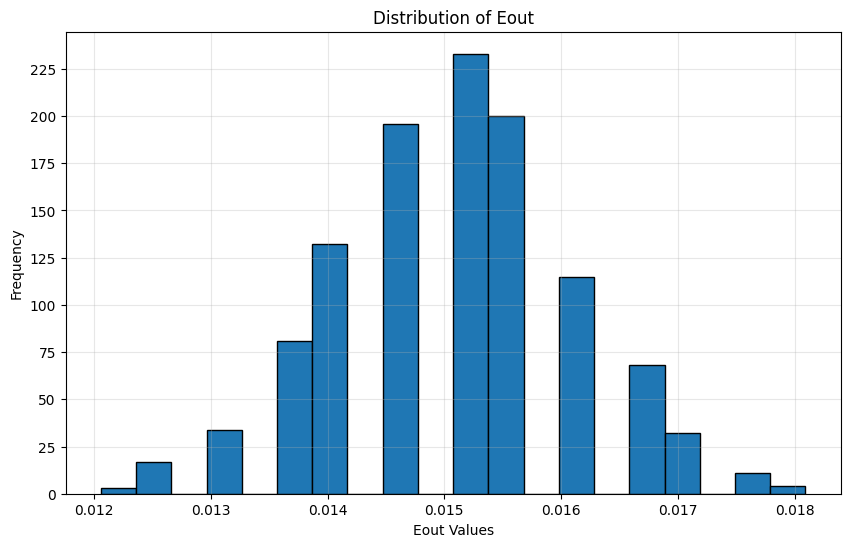

Mean Eout: 0.0150
Standard Deviation: 0.0010


In [12]:
plt.figure(figsize=(10, 6))
plt.hist(Eouts, bins=20, edgecolor='black')
plt.xlabel('Eout Values')
plt.ylabel('Frequency')
plt.title('Distribution of Eout')
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()

# print mean and standard deviation in order to compare the result with the previous question
print(f"Mean Eout: {np.mean(Eouts):.4f}")
print(f"Standard Deviation: {np.std(Eouts):.4f}")

In [14]:
print("\nStatistics for Eout:")
print(f"Mean: {np.mean(Eouts):.4f}")
print(f"Median: {np.median(Eouts):.4f}")
print(f"Standard Deviation: {np.std(Eouts):.4f}")
print(f"Min: {np.min(Eouts):.4f}")
print(f"Max: {np.max(Eouts):.4f}")


Statistics for Eout:
Mean: 0.0150
Median: 0.0151
Standard Deviation: 0.0010
Min: 0.0121
Max: 0.0181
